<a href="https://colab.research.google.com/github/EddyB1337/AtariDeepQ/blob/master/AtariDeepQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install supersuit
from supersuit import color_reduction_v0, frame_stack_v1

/usr/local/lib/python3.7/dist-packages/supersuit/__init__.py:20: UserWarning: You're using SuperSuit 3.0, released 7/7/21. The entire codebase has been rewritten or refactored as part of this release. While we've tested it thoroughly, please ensure everything you're doing still works properly and report any issues at https://github.com/PettingZoo-Team/SuperSuit. This warning will be removed 2 months after release.
  warnings.warn("You're using SuperSuit 3.0, released 7/7/21. The entire codebase has been rewritten or refactored as part of this release. While we've tested it thoroughly, please ensure everything you're doing still works properly and report any issues at https://github.com/PettingZoo-Team/SuperSuit. This warning will be removed 2 months after release.")


In [3]:
import numpy as np
import gym 
import urllib.request
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
!pip install unrar
!unrar x Roms.rar
!mkdir rars
!mv HC\ ROMS.zip   rars
!mv ROMS.zip  rars
!python -m atari_py.import_roms rars


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from Roms.rar

Extracting  HC ROMS.zip                                                   36%  OK 
Extracting  ROMS.zip                                                      74% 99%  OK 
All OK
mkdir: cannot create directory ‘rars’: File exists
copying adventure.bin from ROMS/Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from ROMS/Air Raid (Men-A-Vision) (PAL) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/air_raid.bin
copying alien.bin from ROMS/Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/alien.bin
copying amidar.bin from ROMS/Amidar (1982) (Parker Brothers, Ed Temple) (PB5310) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_

In [4]:
import torch 
from collections import deque 
from torchvision import transforms
import random
from tqdm.notebook import trange

In [91]:
!pip install wandb
import wandb

     |████████████████████████████████| 1.7 MB 7.2 MB/s 
     |████████████████████████████████| 170 kB 38.3 MB/s 
     |████████████████████████████████| 133 kB 36.8 MB/s 
     |████████████████████████████████| 188 kB 37.8 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=fab0f43fcd351d043f438854fdb5accb13b7e3c47b54c7fb96255fc337509ecc
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [86]:
import torch.nn as nn

class deep_Q(nn.Module):

  def __init__(self):
    super(deep_Q, self).__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(3,32,3,2, bias=False),
        nn.BatchNorm2d(32),
        nn.ReLU()
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(32, 64, 3, 2, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )

    self.conv3 = nn.Sequential(
        nn.Conv2d(64, 64, 3, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.linear = nn.Linear(1024, 4)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    self.to(device)

  def forward(self, x):
    x = self.conv3(self.conv2(self.conv1(x)))
    return self.linear(x.view(x.size(0), -1))


In [96]:
A = Atari_agent(lr=3e-4)
A.train(1000)

reward,0.0
loss,0.03457
_runtime,253
_timestamp,1627847987
_step,26099


reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂█▁▁▃▇▁▁▁▁▁▁▁█▁▁▁▁▂▁▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [63]:
AtariEnv = gym.make('Breakout-v0')
AtariEnv = frame_stack_v1(color_reduction_v0(AtariEnv, mode='full'), 3)

In [95]:
import matplotlib.pyplot as plt
class Atari_agent:

  def __init__(self, env=AtariEnv, batch_size = 64, discount=0.99,epsilon=1.0, epsilon_min=0.1, lr=3e-4, epsilon_decay = 0.99):
    self.discount = discount
    self.env = env
    self.epsilon = epsilon
    self.epsilon_min = epsilon_min
    
    self.D = deque(maxlen=10000)
    self.batch_size = batch_size
    
    self.epsilon_decay = epsilon_decay
    self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    self.criterion = nn.MSELoss()
    self.Q = deep_Q().to(self.device)
    self.optimizer = torch.optim.Adam(self.Q.parameters(), lr = lr)

    wandb.init(project="Atari")
    wandb.watch(self.Q)


  def get_epsilon(self, t):
        return max(self.epsilon_min, min(self.epsilon, 1.0 - np.log((t + 1) * self.epsilon_decay)))

  def get_action(self, state, e):
    with torch.no_grad():
      if np.random.uniform(0,1) < e : 
        return self.env.action_space.sample()
      else:
        state = np.expand_dims(state, axis=0)
        return torch.argmax(self.Q(torch.tensor(state, dtype=torch.float, device=self.device))).item()

  def store_transition(self, state, action, reward, next_state, done):
    self.D.append((state, action, reward, next_state, done))

  def create_minibatch_transitions(self):
    transitions = np.array(random.sample(self.D, self.batch_size), dtype=object)
    states = np.stack(transitions[:,0]).astype(float)
    actions = transitions[:,1].astype(int)
    rewards = transitions[:,2].astype(float)
    next_states = np.stack(transitions[:,3]).astype(float)
    dones = transitions[:,4].astype(bool)
    return states, actions, rewards, next_states, dones

  def preprocess(self, s):
    x_1 = torch.from_numpy(s.T).float()
    transform = transforms.Compose([transforms.Resize((30,40)),
                                  transforms.CenterCrop((28,35))
                                  ])
    # crop above, drop the first 5 rows
    tensor_img = torch.transpose(transform(x_1).reshape((3,28,35)), 1,2)[:,5:,:,]
    return tensor_img.cpu().detach().numpy()


  def train(self, num_episodes):
    for episode in trange(num_episodes):

      state = self.preprocess(self.env.reset())
      done = False
      eps_rewards = []
      while not done:

        action = self.get_action(state, self.get_epsilon(episode))
        next_state, reward, done, _ = self.env.step(action)
        next_state = self.preprocess(next_state)

        eps_rewards.append(reward)

        self.store_transition(state, action, reward, next_state, done)
        state = next_state

        if len(self.D) >= self.batch_size and not done:
          states, actions, rewards, next_states, dones = self.create_minibatch_transitions()

          not_dones = ~dones
          with torch.no_grad():
            next_states = torch.from_numpy(next_states).float().to(self.device)
            next_state_values = np.max(self.Q(next_states).cpu().data.numpy(), axis=1)[not_dones] 

          y = rewards.copy()
          y[not_dones] += self.discount * next_state_values
          y = torch.from_numpy(y).float().to(self.device)
          
          states = torch.from_numpy(states).float().to(self.device)
          action_values = self.Q(states)[np.arange(self.batch_size), actions]

          self.optimizer.zero_grad()
          output = self.criterion(y, action_values)
          output.backward()
          self.optimizer.step()
          wandb.log({'reward':reward, 'loss':output, 'epsilon':self.epsilon})  
        
      if self.epsilon <= self.epsilon_min:
        self.epsilon = self.epsilon_min
      else:
        self.epsilon *= self.epsilon_decay








In [65]:
s = AtariEnv.reset()
ag = Atari_agent()
s = ag.preprocess(s)


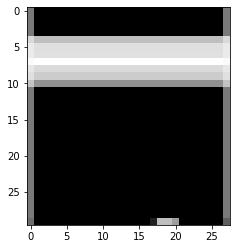

In [61]:
plt.imshow(s[2], cmap="gray")


In [69]:
A = Atari_agent(lr=3e-4)
A.train(1000)

torch.Size([64, 16, 1, 1])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


RuntimeError: ignored

In [ ]:
testEnv = gym.make('CartPole-v0')

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
testEnv.reset()

In [ ]:
class test_Q(nn.Module):

  def __init__(self):
    super(test_Q, self).__init__()
    self.linear1 = nn.Sequential(
        nn.Linear(4, 16),
        nn.ReLU()
    )
    self.linear2 = nn.Sequential(
        nn.Linear(16, 32),
        nn.ReLU()
    )
    self.linear3 = nn.Sequential(
        nn.Linear(32, 64),
        nn.ReLU()
    )
    self.linear4 = nn.Sequential(
        nn.Linear(64, 32),
        nn.ReLU()
    )
    self.linear5 = nn.Sequential(
        nn.Linear(32, 16),
        nn.ReLU()
    )
    self.linear6 = nn.Sequential(
        nn.Linear(16, 8),
        nn.ReLU(),
        nn.Linear(8,2)
    )
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    self.to(device)

  def forward(self, x):
    x = self.linear1(x)
    #x = self.linear2(x)
    #x = self.linear3(x)
    #x = self.linear4(x)
    #x = self.linear5(x)
    return self.linear6(x)

 

In [ ]:
class Agent:

  def __init__(self, env, batch_size = 64, discount=0.9,epsilon=1.0, epsilon_min=0.01, lr=0.01, epsilon_decay = 0.995):
    self.discount = discount
    self.env = env
    self.epsilon = epsilon
    self.epsilon_min = epsilon_min
    
    self.D = deque(maxlen=100000)
    self.batch_size = batch_size
    
    self.epsilon_decay = epsilon_decay
    self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    self.criterion = nn.MSELoss()
    self.Q = test_Q().to(self.device)
    self.optimizer = torch.optim.RMSprop(self.Q.parameters(), lr = lr)

  def get_epsilon(self, t):
        return max(self.epsilon_min, min(self.epsilon, 1.0 - np.log((t + 1) * self.epsilon_decay)))

  def get_action(self, state, e):
    with torch.no_grad():
      if np.random.uniform(0,1) < e : 
        return int(np.random.uniform(0,2))
      else:
        return torch.argmax(self.Q(torch.tensor(state, dtype=torch.float, device=self.device))).item()

  def store_transition(self, state, action, reward, next_state, done):
    self.D.append((state, action, reward, next_state, done))

  def create_minibatch_transitions(self):
    transitions = np.array(random.sample(self.D, self.batch_size))
    states = np.stack(transitions[:,0]).astype(float)
    actions = transitions[:,1].astype(int)
    rewards = transitions[:,2].astype(float)
    next_states = np.stack(transitions[:,3]).astype(float)
    dones = transitions[:,4].astype(bool)
    return states, actions, rewards, next_states, dones

  def train(self, num_episodes):

    for episode in trange(num_episodes):

      state = self.env.reset()
      done = False
      eps_rewards = []
      while not done:

        action = self.get_action(state, self.get_epsilon(episode))
        next_state, reward, done, _ = self.env.step(action)

        eps_rewards.append(reward)

        self.store_transition(state, action, reward, next_state, done)
        state = next_state

        if len(self.D) >= self.batch_size and not done:
          states, actions, rewards, next_states, dones = self.create_minibatch_transitions()

          not_dones = ~dones
          with torch.no_grad():
            next_states = torch.from_numpy(next_states).float().to(self.device)
            next_state_values = np.max(self.Q(next_states).cpu().data.numpy(), axis=1)[not_dones] 

          y = rewards.copy()
          y[not_dones] += self.discount * next_state_values
          y = torch.from_numpy(y).float().to(self.device)
          
          states = torch.from_numpy(states).float().to(self.device)
          action_values = self.Q(states)[np.arange(self.batch_size), actions]

          self.optimizer.zero_grad()
          output = self.criterion(y, action_values)
          output.backward()
          self.optimizer.step()
        
      if episode % 50 == 0:
        print(np.sum(eps_rewards))
      if self.epsilon <= self.epsilon_min:
        self.epsilon = self.epsilon_min
      else:
        self.epsilon *= self.epsilon_decay


  

In [ ]:
agent_test = Agent(testEnv, lr=0.01)
agent_test.train(1000)

In [ ]:
Q_n = test_Q()
Q_n(torch.from_numpy(testEnv.observation_space.sample()).float().to(device))